In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
import json
from dotenv import load_dotenv, find_dotenv

In [3]:
load_dotenv(find_dotenv())

True

In [4]:
project = hopsworks.login(
    engine="python",
    project=os.getenv("HOPSWORKS_PROJECT"),
    api_key_value=os.getenv("HOPSWORKS_API_KEY"),
)
fs = project.get_feature_store()

2026-01-03 12:22:21,348 INFO: Initializing external client
2026-01-03 12:22:21,348 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-03 12:22:23,069 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279162


In [56]:
flights_fg = fs.get_feature_group("flights_fg", version=1)
weather_fg = fs.get_feature_group("weather_fg", version=1)
coords_fg = fs.get_feature_group("airport_coords_fg", version=1)

In [57]:
# 1. Join weather for the departure airport
# 2. Join weather for the arrival airport (using a prefix)
# 3. Join coordinates for both (optional, but good for distance calculation)

query = flights_fg.select_all() \
    .join(weather_fg.select_all(), 
          left_on=["dep_airport"],
          right_on=["airport_iata"],
          prefix="dep_")

In [58]:
label_encoder = fs.get_transformation_function(name="label_encoder")

feature_view = fs.get_or_create_feature_view(
    name="flight_delay_fv",
    version=1,
    query=query,
    labels=["dep_delay", "arr_delay"],
    transformation_functions=[
        label_encoder("dep_airport"),
        label_encoder("arr_airport"),
        label_encoder("airline"),
    ]
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1279162/fs/1265774/fv/flight_delay_fv/version/1


In [68]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_size=0.2,
    primary_key=True,
)
X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (38.76s) 
2026-01-03 17:13:34,430 WARNING: VersionWarning: Incremented version to `2`.

2026-01-03 17:13:34,431 INFO: Provenance cached data - overwriting last accessed/created training dataset from 1 to 2.


,flight_iata,dep_time_sched,dep_time_actual,arr_time_sched,arr_time_actual,dep_weather_timestamp,dep_temperature_2m,dep_precipitation,dep_wind_speed_10m,dep_airport_iata,label_encoder_airline_,label_encoder_arr_airport_,label_encoder_dep_airport_
0,d0708,2025-01-21 16:00:00+00:00,2025-01-21 16:15:00+00:00,2025-01-21 20:48:00+00:00,2025-01-21 20:44:00+00:00,2025-01-21 16:00:00+00:00,17.6,0.0,13.6,bah,58,0,22
1,d0706,2025-02-09 16:45:00+00:00,2025-02-09 17:00:00+00:00,2025-02-09 21:24:00+00:00,2025-02-09 21:23:00+00:00,2025-02-09 16:00:00+00:00,16.6,0.0,15.4,bah,58,0,22
2,d0706,2025-03-16 16:45:00+00:00,2025-03-16 17:06:00+00:00,2025-03-16 21:10:00+00:00,2025-03-16 21:23:00+00:00,2025-03-16 16:00:00+00:00,21.4,0.0,15.4,bah,58,0,22
3,sk2962,2025-03-30 11:20:00+00:00,2025-03-30 11:39:00+00:00,2025-03-30 13:30:00+00:00,2025-03-30 13:37:00+00:00,2025-03-30 11:00:00+00:00,18.6,0.0,21.5,flr,143,0,100
4,sk2962,2025-03-31 12:20:00+00:00,2025-03-31 12:25:00+00:00,2025-03-31 14:30:00+00:00,2025-03-31 14:36:00+00:00,2025-03-31 12:00:00+00:00,17.3,0.0,18.6,flr,143,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284372,sk1794,2025-12-25 20:10:00+00:00,2025-12-25 20:11:00+00:00,2025-12-25 22:15:00+00:00,2025-12-25 22:10:00+00:00,2025-12-25 20:00:00+00:00,-0.3,0.0,1.5,lys,143,0,180
284373,sk1794,2025-12-26 20:10:00+00:00,2025-12-26 20:23:00+00:00,2025-12-26 22:15:00+00:00,2025-12-26 22:16:00+00:00,2025-12-26 20:00:00+00:00,-0.2,0.0,3.0,lys,143,0,180
284374,dy9743,2025-12-27 16:45:00+00:00,2025-12-27 17:04:00+00:00,2025-12-27 18:50:00+00:00,2025-12-27 19:05:00+00:00,2025-12-27 16:00:00+00:00,1.1,0.0,5.5,lys,125,0,180
284377,wx1794,2025-12-28 20:10:00+00:00,2025-12-28 20:57:00+00:00,2025-12-28 22:15:00+00:00,2025-12-28 22:51:00+00:00,2025-12-28 20:00:00+00:00,-0.9,0.0,3.8,lys,52,0,180


In [69]:
y_train

,dep_delay,arr_delay
0,16,0
1,15,0
2,22,14
3,19,7
4,5,7
...,...,...
284372,2,0
284373,14,2
284374,20,16
284377,47,37


In [70]:
# Get a reference to the group
cph_weather_fg = fs.get_feature_group("cph_weather_fg", version=2)

# Read the entire table into a Pandas DataFrame
cph_weather_df = cph_weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.54s) 


In [71]:
cph_weather_cols = {col: f'arr_{col}' for col in cph_weather_df.columns if col not in ['airport_iata']}
cph_weather_df_prefixed = cph_weather_df.rename(columns=cph_weather_cols)

In [72]:
# 1. Normalize X_train
X_train['arr_time_sched'] = pd.to_datetime(X_train['arr_time_sched'], utc=True).dt.tz_convert('UTC').astype('datetime64[ns, UTC]')

# 2. Normalize X_test (don't forget this one!)
X_test['arr_time_sched'] = pd.to_datetime(X_test['arr_time_sched'], utc=True).dt.tz_convert('UTC').astype('datetime64[ns, UTC]')

# 3. Normalize cph_weather_df_prefixed
cph_weather_df_prefixed['arr_weather_timestamp'] = pd.to_datetime(cph_weather_df_prefixed['arr_weather_timestamp'], utc=True).dt.tz_convert('UTC').astype('datetime64[ns, UTC]')

# 4. Re-sort (just to be safe, asof merge requires sorting)
X_train = X_train.sort_values('arr_time_sched')
X_test = X_test.sort_values('arr_time_sched')
cph_weather_df_prefixed = cph_weather_df_prefixed.sort_values('arr_weather_timestamp')

# 5. Now the merge will work perfectly
X_train = pd.merge_asof(
    X_train, 
    cph_weather_df_prefixed, 
    left_on='arr_time_sched', 
    right_on='arr_weather_timestamp',
    direction='backward'
)

X_test = pd.merge_asof(
    X_test, 
    cph_weather_df_prefixed, 
    left_on='arr_time_sched', 
    right_on='arr_weather_timestamp',
    direction='backward'
)

In [73]:
X_train


,flight_iata,dep_time_sched,dep_time_actual,arr_time_sched,arr_time_actual,dep_weather_timestamp,dep_temperature_2m,dep_precipitation,dep_wind_speed_10m,dep_airport_iata,label_encoder_airline_,label_encoder_arr_airport_,label_encoder_dep_airport_,arr_weather_timestamp,arr_temperature_2m,arr_precipitation,arr_wind_speed_10m,airport_iata
0,wt436,2025-01-03 01:35:00+00:00,2025-01-03 01:49:00+00:00,2025-01-03 04:20:00+00:00,2025-01-03 04:15:00+00:00,2025-01-03 01:00:00+00:00,-2.0,0.0,12.3,ema,158,0,90,2025-01-03 04:00:00+00:00,0.1,0.0,24.7,cph
1,ag4215,2025-01-03 03:36:00+00:00,2025-01-03 04:17:00+00:00,2025-01-03 05:30:00+00:00,2025-01-03 05:49:00+00:00,2025-01-03 03:00:00+00:00,-1.5,0.0,6.1,cdg,30,0,61,2025-01-03 05:00:00+00:00,0.2,0.0,27.3,cph
2,sk974,2025-01-02 22:50:00+00:00,2025-01-02 23:07:00+00:00,2025-01-03 05:55:00+00:00,2025-01-03 04:54:00+00:00,2025-01-02 22:00:00+00:00,20.4,0.0,2.3,bkk,143,0,38,2025-01-03 05:00:00+00:00,0.2,0.0,27.3,cph
3,tg950,2025-01-03 00:05:00+00:00,2025-01-03 00:29:00+00:00,2025-01-03 06:20:00+00:00,2025-01-03 05:55:00+00:00,2025-01-03 00:00:00+00:00,19.8,0.0,2.6,bkk,164,0,38,2025-01-03 06:00:00+00:00,0.8,0.0,30.3,cph
4,ac7453,2025-01-03 00:05:00+00:00,2025-01-03 00:29:00+00:00,2025-01-03 06:20:00+00:00,2025-01-03 05:55:00+00:00,2025-01-03 00:00:00+00:00,19.8,0.0,2.6,bkk,8,0,38,2025-01-03 06:00:00+00:00,0.8,0.0,30.3,cph
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227498,sq2020,2025-12-30 21:50:00+00:00,2025-12-30 21:59:00+00:00,2025-12-30 23:15:00+00:00,2025-12-30 23:08:00+00:00,2025-12-30 21:00:00+00:00,-2.2,0.0,1.8,fra,145,0,103,2025-12-30 23:00:00+00:00,-0.6,0.0,13.7,cph
227499,a31404,2025-12-30 21:50:00+00:00,2025-12-30 21:59:00+00:00,2025-12-30 23:15:00+00:00,2025-12-30 23:08:00+00:00,2025-12-30 21:00:00+00:00,-2.2,0.0,1.8,fra,0,0,103,2025-12-30 23:00:00+00:00,-0.6,0.0,13.7,cph
227500,ey3780,2025-12-30 21:50:00+00:00,2025-12-30 21:59:00+00:00,2025-12-30 23:15:00+00:00,2025-12-30 23:08:00+00:00,2025-12-30 21:00:00+00:00,-2.2,0.0,1.8,fra,68,0,103,2025-12-30 23:00:00+00:00,-0.6,0.0,13.7,cph
227501,fr745,2025-12-30 20:55:00+00:00,2025-12-30 21:02:00+00:00,2025-12-30 23:55:00+00:00,2025-12-30 23:42:00+00:00,2025-12-30 20:00:00+00:00,2.3,0.0,10.3,brs,140,0,51,2025-12-30 23:00:00+00:00,-0.6,0.0,13.7,cph


In [109]:
features = [
    'dep_temperature_2m','dep_wind_speed_10m','dep_precipitation',
    #'label_encoder_airline_', 'label_encoder_dep_airport_'
]

X_train_final = X_train[features]
X_test_final = X_test[features]

In [110]:
from sklearn.metrics import mean_absolute_error, r2_score

# Initialize the model
xgb_model = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=6, 
    random_state=42
)

# Train
xgb_model.fit(X_train_final, y_train['dep_delay'])

# Predict and Evaluate
xgb_preds = xgb_model.predict(X_test_final)
print(f"XGBoost MAE: {mean_absolute_error(y_test['dep_delay'], xgb_preds):.2f} minutes")

XGBoost MAE: 14.93 minutes


In [111]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10, 
    random_state=42,
    n_jobs=-1 # Uses all CPU cores
)

# Train
rf_model.fit(X_train_final, y_train['dep_delay'])

# Predict and Evaluate
rf_preds = rf_model.predict(X_test_final)
print(f"Random Forest MAE: {mean_absolute_error(y_test['dep_delay'], rf_preds):.2f} minutes")

Random Forest MAE: 14.91 minutes


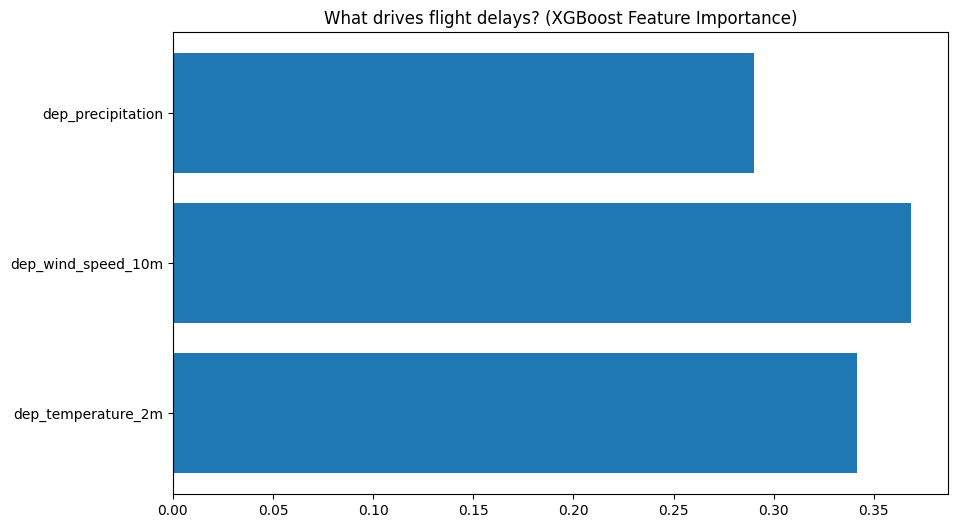

In [112]:
import matplotlib.pyplot as plt

# Plotting XGBoost Importance
plt.figure(figsize=(10, 6))
plt.barh(features, xgb_model.feature_importances_)
plt.title("What drives flight delays? (XGBoost Feature Importance)")
plt.show()

In [113]:
from sklearn.metrics import r2_score, mean_absolute_error

# XGBoost Evaluation
xgb_mae = mean_absolute_error(y_test['dep_delay'], xgb_preds)
xgb_r2 = r2_score(y_test['dep_delay'], xgb_preds)

# Random Forest Evaluation
rf_mae = mean_absolute_error(y_test['dep_delay'], rf_preds)
rf_r2 = r2_score(y_test['dep_delay'], rf_preds)

print(f"XGBoost -> MAE: {xgb_mae:.2f} min, R2: {xgb_r2:.4f}")
print(f"Random Forest -> MAE: {rf_mae:.2f} min, R2: {rf_r2:.4f}")

XGBoost -> MAE: 14.93 min, R2: -0.0008
Random Forest -> MAE: 14.91 min, R2: -0.0005
